<a href="https://colab.research.google.com/github/hrith/WindShield-Detection/blob/master/corner_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [1]:
!git clone https://github.com/hrith/WindShield-Detection.git

Cloning into 'WindShield-Detection'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 26 (delta 1), reused 25 (delta 0), pack-reused 0
Unpacking objects: 100% (26/26), done.


In [2]:
%cd WindShield-Detection

/content/WindShield-Detection


In [3]:
!pip install -r requirements.txt
!pip install tensorflow==1.15
!pip install keras==2.1
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!pip install imgaug
!wget http://acctaxcpa.com/weight.h5

     |████████████████████████████████| 163kB 12.4MB/s 
     |████████████████████████████████| 204kB 29.0MB/s 
     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 512kB 44.0MB/s 
     |████████████████████████████████| 3.8MB 47.6MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=7eab3aa23abda6fbfec8597051bfe89c612588f14868d9235c55099072b9f19d
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstal

# Windshield Training Code

In [4]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
import json
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline
from os import listdir
from imgaug import augmenters as iaa

Using TensorFlow backend.


In [5]:
# Initializing Mask Rcnn configuration for windshield detection
class WindShieldConfig(Config):
    NAME = "WindShield_config"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 2+1
    STEPS_PER_EPOCH = 131
    LEARNING_RATE=0.006
    DETECTION_MIN_CONFIDENCE = 0.1
    MAX_GT_INSTANCES=10

config = WindShieldConfig()

In [6]:
# Data Augmentation 
data_augmentation = iaa.Sequential([
    iaa.Crop(px=(0, 16)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.GaussianBlur(sigma=(0, 3.0)),
    iaa.AverageBlur(k=(2, 7)),
    iaa.MedianBlur(k=(3, 11)),
    iaa.LinearContrast((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
    iaa.EdgeDetect(alpha=(0, 0.7)),
    iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0)),
    iaa.Invert(0.05, per_channel=True),
    iaa.Add((-10, 10), per_channel=0.5),
    iaa.Grayscale(alpha=(0.0, 1.0)),
    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25),
    iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255)),
    
], random_order=True)

In [7]:
# Loading Dataset
class LoadDataset(Dataset):
    # Loading image refrences
    def load_dataset(self, dataset_dir, is_train=True):
        images_dir = "dataset"
        self.add_class(images_dir, 1, "head_light")
        self.add_class(images_dir, 2, "windshield")
        
        for filename in listdir(images_dir):
          fn = filename.split(".")
          if fn[-1] != "json":
            image_id = ".".join(fn[:-1])
            img_path = images_dir + "/" + filename
            ann_path = images_dir + "/" + image_id + '.json'
            self.add_image(images_dir, image_id=image_id, path=img_path, annotation=ann_path)

    # Creating Masks
    def c_extract_ann_dt(self,ann_path):
      with open(ann_path) as f:
        ann_data = json.load(f)
        h = ann_data['imageHeight']
        w = ann_data['imageWidth']
        print(ann_path)
        classes = []
        masks = []
        for dt in ann_data["shapes"]:
          mask = zeros([h, w], dtype='uint8')
          polygon = np.array([[[int(coords[0]), int(coords[1])] for coords in dt["points"]]])
          cv2.fillPoly( mask, polygon, 255 )
          masks.append(mask)
          if dt["label"] == "head_light":
            classes.append(1)
          elif dt["label"] == "windshield":
            classes.append(2)
        return np.array(masks).reshape(h,w, len(classes)), classes

    # Loading masks
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        masks, class_ids = self.c_extract_ann_dt(path)
        return masks, asarray(class_ids, dtype='int32')

    # Creating Image refrences
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [8]:
# Preparing Training Dataset
train_set = LoadDataset()
train_set.load_dataset("dataset", is_train=True)
train_set.prepare()
print("Train: %d" % len(train_set.image_ids))

# Preparing Test DataSet
test_set = LoadDataset()
test_set.load_dataset("dataset", is_train=False)
test_set.prepare()
print("Test: %d" % len(test_set.image_ids))

Train: 5
Test: 5


In [ ]:
# Initializing training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

# Loading pretrained weights
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# Initializing Training
model.train(train_set, test_set, learning_rate=2*config.LEARNING_RATE, epochs=5, layers="heads", augmentation=data_augmentation)

In [ ]:
history = model.keras_model.history.history

In [ ]:
# Storing weight file
model_path = 'weight.h5'
model.keras_model.save_weights(model_path)

# Inference Code

original
(870, 1531, 3)


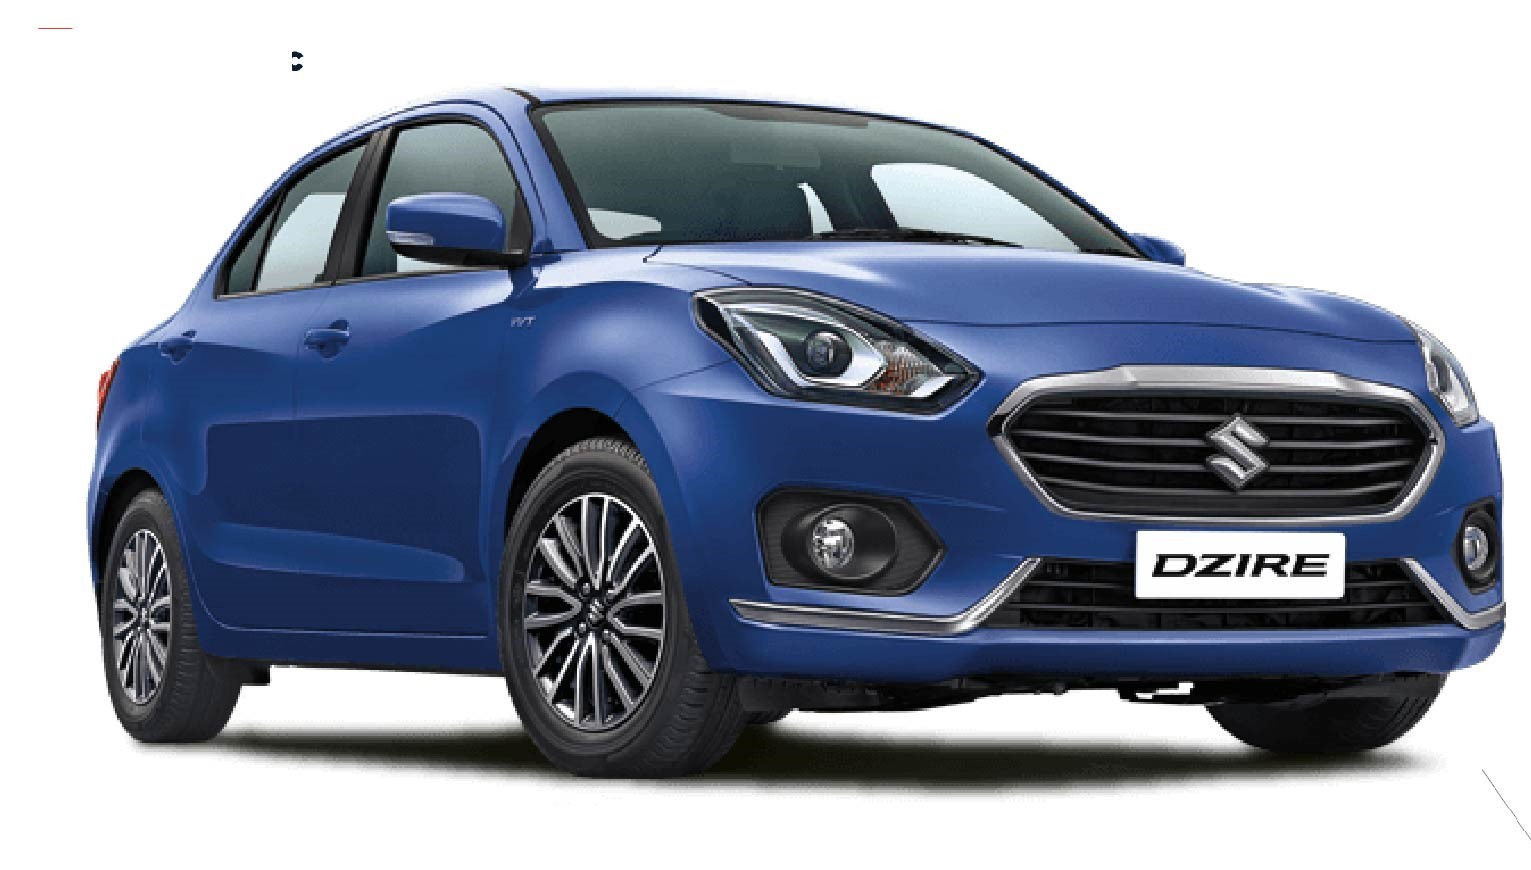

Car Detected
(696, 1406, 3)


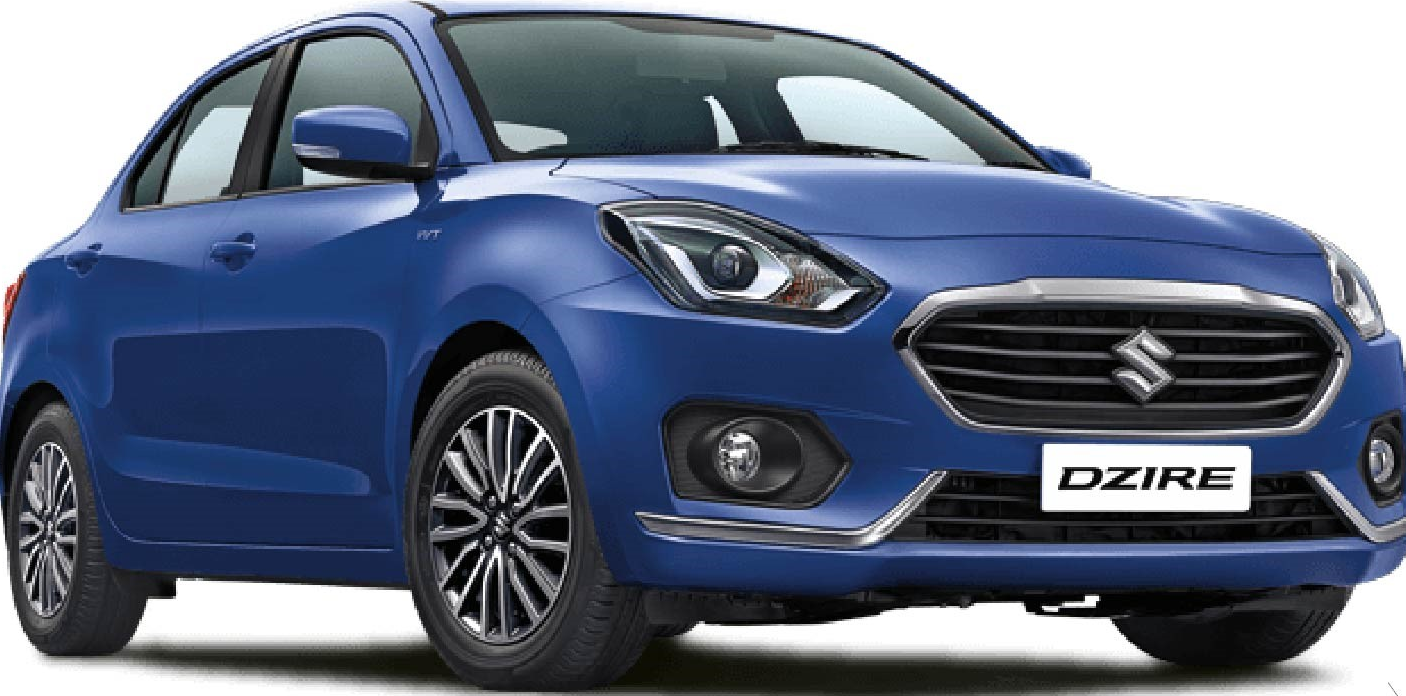

mask
(696, 1406, 1)


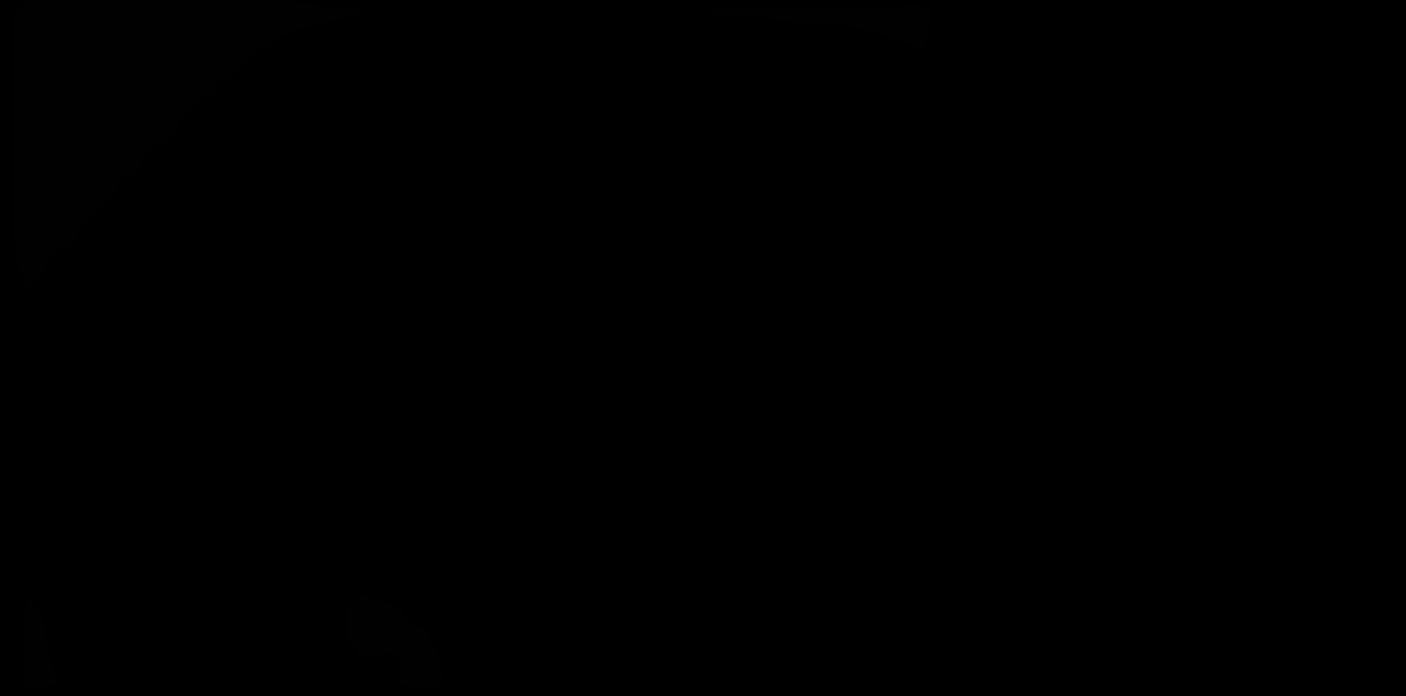

windshield detection
(696, 1406, 3)


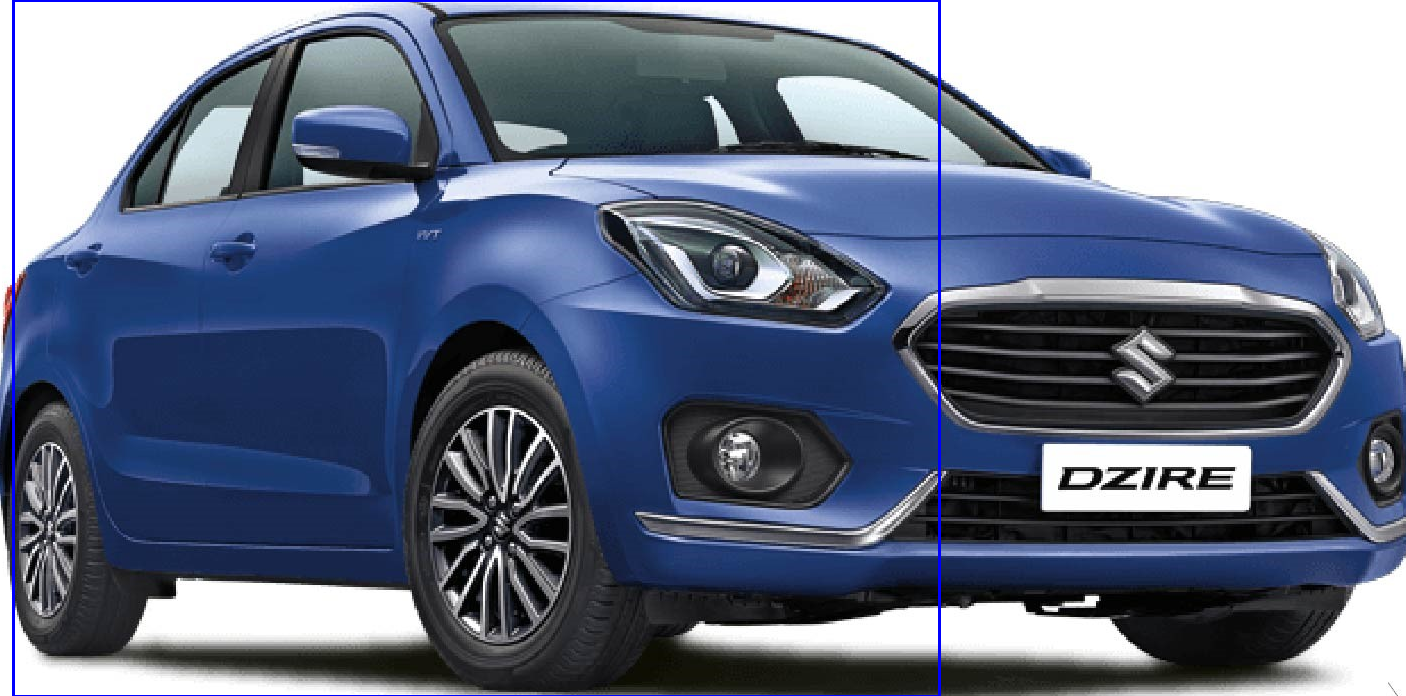

In [12]:
############################################################################################
# weight.h5 is output of just a single epoch and trained on just 5 images with two classes #
############################################################################################

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from google.colab.patches import cv2_imshow

# draw an image with detected objects
def draw_boxes(img, boxes_list):
     for box in boxes_list:
          y1, x1, y2, x2 = box
          cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
     print("windshield detection")
     print(img.shape)
     cv2_imshow(img)

# Load model using weights and configuration
def load_inf_model(path, config):
  model = MaskRCNN(mode='inference', model_dir='./', config=config)
  model.load_weights(path, by_name=True)
  return model

# WindShield Extraction
def extract_windshield(filename, boxes_list, classes_list):
     data = cv2.imread(filename)
     ids = [3,6,8]
     for i in range(len(boxes_list)):
          if classes_list[i] in ids:
            y1, x1, y2, x2 = boxes_list[i]
            img = data[y1:y2, x1:x2]
            print("Car Detected")
            print(img.shape)
            cv2_imshow(img)
            windshield_detection = load_inf_model("weight.h5", WindShieldConfig())
            results = windshield_detection.detect([img], verbose=0)
            print("mask")
            print(results[0]['masks'].shape)
            cv2_imshow(results[0]['masks'])
            draw_boxes(img, results[0]['rois'])

# Initializing configuration for pre-trained car detectin model
class TestConfig(Config):
     NAME = "test"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 80

# Loading image for inference
img = cv2.imread('dataset/car-1.jpg')
print("original")
print(img.shape)
cv2_imshow(img)
car_detection = load_inf_model('mask_rcnn_coco.h5', TestConfig())
results = car_detection.detect([img], verbose=0)
extract_windshield('dataset/car-1.jpg', results[0]['rois'], results[0]['class_ids'])

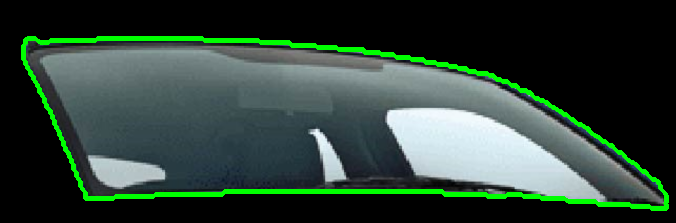

In [10]:
image = cv2.imread('windshield.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
contours, hierarchy = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
cv2.drawContours(image, contours, -1, (0, 255, 0), 3) 
cv2_imshow(image)